In [1]:
import torch
import matplotlib.pyplot as plt
import torchaudio
from torchaudio.utils import download_asset
import IPython

In [2]:
torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device used:", device)
print("Number of GPUs:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0))

Device used: cuda
Number of GPUs: 1
Device name: NVIDIA GeForce GTX 1650


In [3]:
SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

100%|████████████████████████████████████████| 106k/106k [00:00<00:00, 1.53MB/s]


In [4]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [5]:
model = bundle.get_model().to(device)
print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /home/anurag/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|████████████████████████████████████████| 360M/360M [01:21<00:00, 4.61MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [6]:
IPython.display.Audio(SPEECH_FILE)

In [7]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [8]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

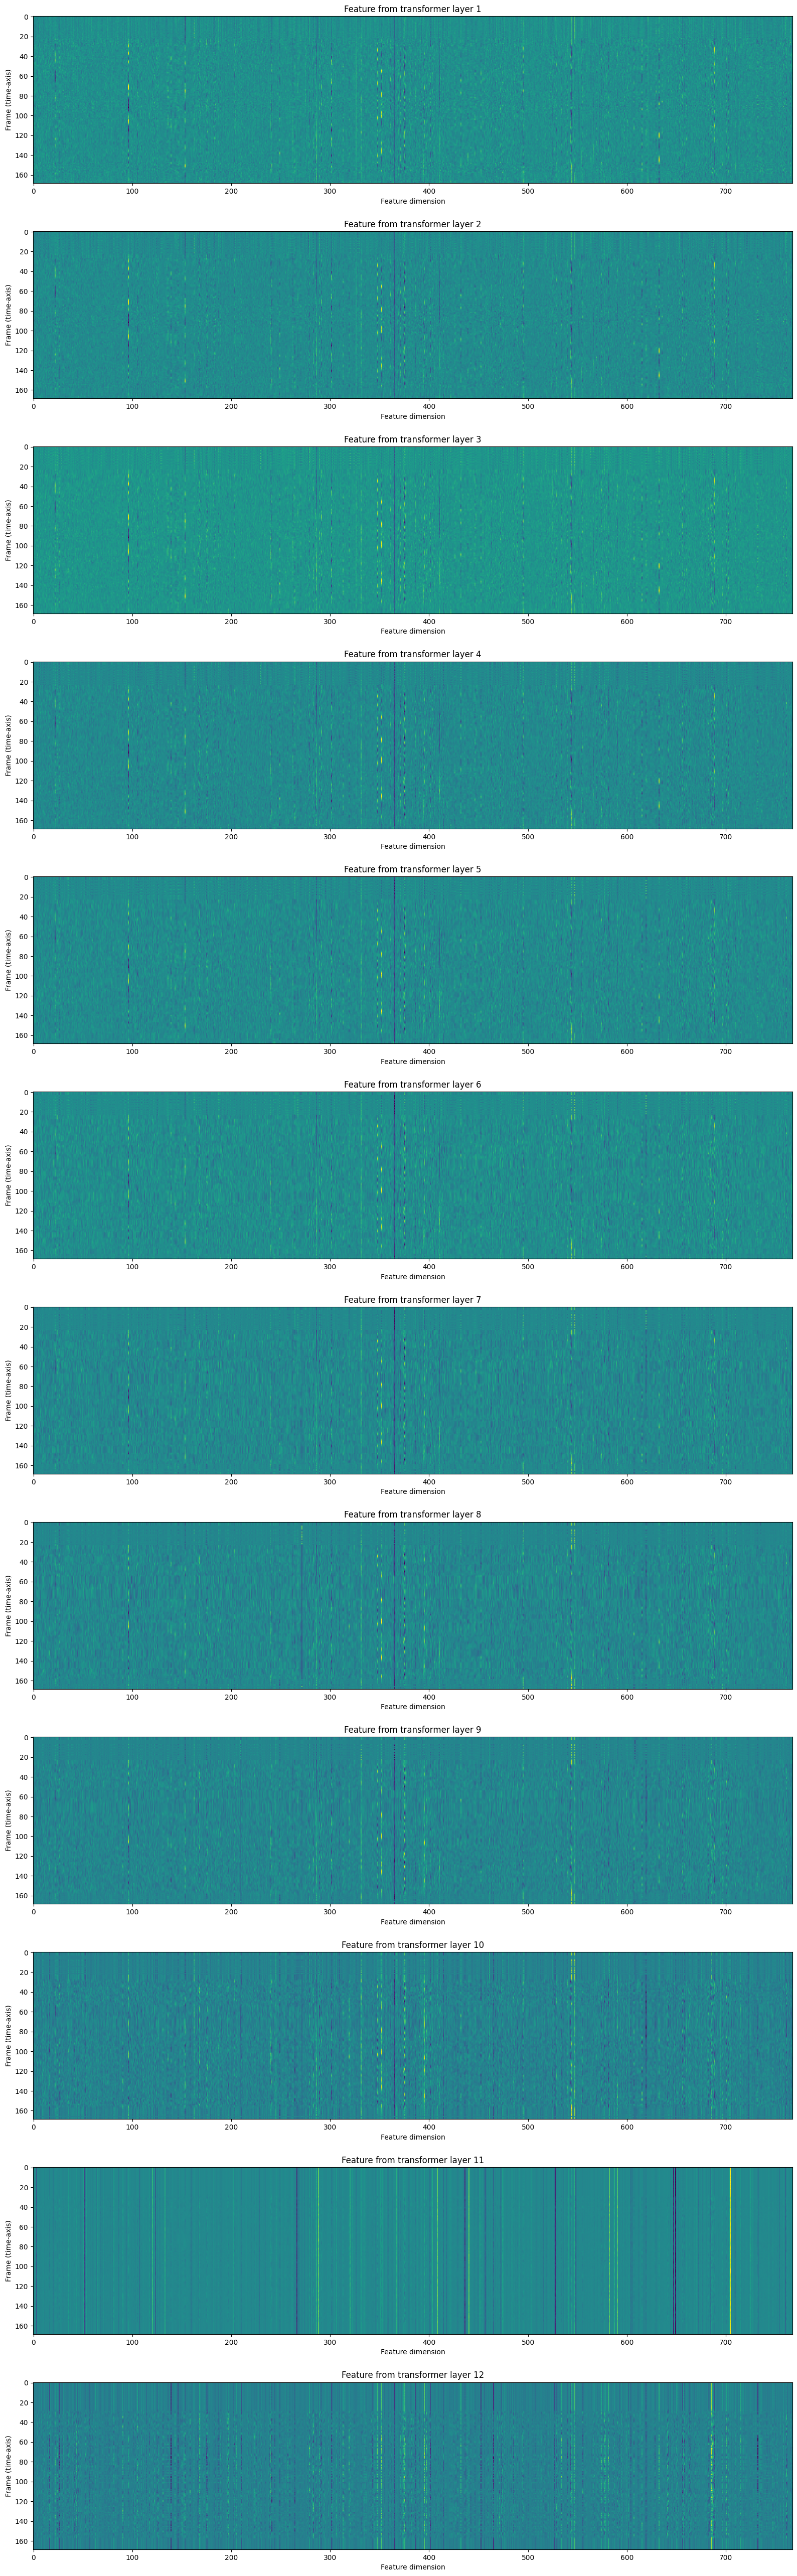

In [9]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [10]:
with torch.inference_mode():
    emission, _ = model(waveform)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


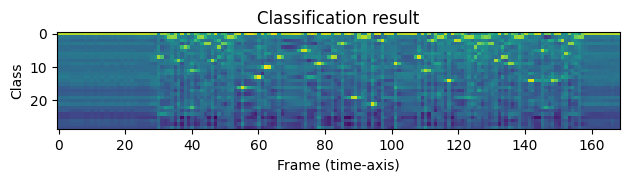

In [11]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [12]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        indices = torch.argmax(emission, dim=-1) 
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [13]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [14]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In [15]:
model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
torch.save(model.state_dict(), './model.pth')
torch.save(model.state_dict(), './model.pth.tar.gz', _use_new_zipfile_serialization=False)

In [16]:
!pip install yt-dlp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [17]:
import yt_dlp

url = "https://www.youtube.com/watch?v=6uUblznfrsk"

ydl_opts = {
    'outtmpl': './downloads/%(title)s.%(ext)s',
    'format': 'bestvideo+bestaudio/best'
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])

[youtube] Extracting URL: https://www.youtube.com/watch?v=6uUblznfrsk
[youtube] 6uUblznfrsk: Downloading webpage
[youtube] 6uUblznfrsk: Downloading tv client config
[youtube] 6uUblznfrsk: Downloading player 14397202-main
[youtube] 6uUblznfrsk: Downloading tv player API JSON
[youtube] 6uUblznfrsk: Downloading ios player API JSON
[youtube] 6uUblznfrsk: Downloading m3u8 information
[info] 6uUblznfrsk: Downloading 1 format(s): 616+251
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 186
[download] Destination: ./downloads/ENGLISH SPEECH ｜ ANAND MAHINDRA： Purpose in Life (English Subtitles).f616.mp4
[download] 100% of  137.38MiB in 00:01:24 at 1.62MiB/s                   
[download] Destination: ./downloads/ENGLISH SPEECH ｜ ANAND MAHINDRA： Purpose in Life (English Subtitles).f251.webm
[download] 100% of   13.74MiB in 00:00:03 at 4.38MiB/s   
[Merger] Merging formats into "./downloads/ENGLISH SPEECH ｜ ANAND MAHINDRA： Purpose in Life (English Subtitles).webm"
Deleting origin